In [1]:
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.datasets import Planetoid

In [2]:
use_cuda_if_available = False

# Carichiamo il dataset

In [3]:
dataset = Planetoid(root="esempio1",name= "Cora")

##### Caratteristiche del Dataset

In [4]:
print(dataset)
print("numero di grafi:\t\t",len(dataset))
print("number di classi:\t\t",dataset.num_classes)
print("number di feature dei nodi:\t",dataset.num_node_features)
print("number di feature degli archi:\t",dataset.num_edge_features)

Cora()
numero di grafi:		 1
number di classi:		 7
number di feature dei nodi:	 1433
number di feature degli archi:	 0


##### Dataset shapes

In [5]:
print(dataset._data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [6]:
print("edge_index:\t\t",dataset._data.edge_index.shape)
print(dataset._data.edge_index)
print("\n")
print("train_mask:\t\t",dataset._data.train_mask.shape)
print(dataset._data.train_mask)
print("\n")
print("x:\t\t",dataset._data.x.shape)
print(dataset._data.x)
print("\n")
print("y:\t\t",dataset._data.y.shape)
print(dataset._data.y)
print("edge number:\t\t")
print(dataset[0].num_edges)
print("node number:\t\t")
print(dataset[0].num_nodes)

edge_index:		 torch.Size([2, 10556])
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])


train_mask:		 torch.Size([2708])
tensor([ True,  True,  True,  ..., False, False, False])


x:		 torch.Size([2708, 1433])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


y:		 torch.Size([2708])
tensor([3, 4, 4,  ..., 3, 3, 3])
edge number:		
10556
node number:		
2708


In [7]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


In [8]:
data = dataset[0]
print(dataset.num_classes)

7


In [9]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = SAGEConv(dataset.num_features,
                             128,
                             aggr="mean") # max, mean, add ...)
        self.conv2 = SAGEConv(128,
                             64,
                              aggr="mean") # max, mean, add ...)

        self.conv3 = SAGEConv(64,
                             32,
                             aggr="mean") # max, mean, add ...)
        self.conv4 = SAGEConv(32,
                             16,
                             aggr="mean") # max, mean, add ...)
        self.conv5 = SAGEConv(16,
                             8,
                             aggr="max") # max, mean, add ...)
        self.conv6 = SAGEConv(8,
                             dataset.num_classes,
                             aggr="max") # max, mean, add ...)

       # self.classifier = torch.nn.Linear(16, int(dataset.num_classes))
        
    def forward(self):
        x = self.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
       
        x = self.conv2(x,data.edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv3(x,data.edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv4(x,data.edge_index)
        #x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        x = self.conv5(x,data.edge_index)
        out = F.log_softmax(x, dim=1)
        
        #x = self.classifier(x)
        #out = F.sigmoid(x)
        return out, x 
    
    

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda_if_available else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)

In [11]:
device
F

<module 'torch.nn.functional' from '/home/alfredo/python/venv/lib/python3.12/site-packages/torch/nn/functional.py'>

In [12]:
import numpy as np

def train():
    model.train()  # Imposta il modello in modalità training (abilita dropout, batch norm, etc.)
    optimizer.zero_grad()  # Azzera i gradienti dell'ottimizzatore per evitare accumulo
    out, x = model()  # Esegue il forward pass del modello, ritorna output e embedding
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Calcola la negative log likelihood loss sui dati di training
    loss.backward()  # Esegue la backpropagation per calcolare i gradienti
    optimizer.step()  # Aggiorna i parametri del modello usando i gradienti calcolati
    return out, x  # Ritorna l'output del modello e gli embedding


def test():
    model.eval()  # Imposta il modello in modalità valutazione (disabilita dropout, etc.)
    logits,_ = model()  # Esegue il forward pass e ottiene i logits (ignora gli embedding con _)
    accs = []  # Inizializza lista per memorizzare le accuratezze
    for *,mask in data('train*mask', 'val_mask', 'test_mask'):  # Itera sui set di training, validazione e test
        pred = logits[mask].max(1)[1]  # Ottiene le predizioni prendendo l'indice della classe con probabilità massima
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()  # Calcola l'accuratezza come rapporto tra predizioni corrette e totale
        accs.append(acc)  # Aggiunge l'accuratezza alla lista
    return accs  # Ritorna la lista delle accuratezze per train, validation e test


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [13]:
best_val_acc = test_acc = 0
for epoch in range(1,500):
    loss, x =train()
    _,val_acc, tmp_test_acc= test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}'
    
    if epoch % 10 == 0:
        print(log.format(epoch, best_val_acc, test_acc))


Epoch: 010, Val: 0.1220, Test: 0.1300
Epoch: 020, Val: 0.1220, Test: 0.1300
Epoch: 030, Val: 0.1280, Test: 0.1400
Epoch: 040, Val: 0.2100, Test: 0.2280
Epoch: 050, Val: 0.2700, Test: 0.2680
Epoch: 060, Val: 0.2760, Test: 0.2770
Epoch: 070, Val: 0.2800, Test: 0.2860
Epoch: 080, Val: 0.2800, Test: 0.2860
Epoch: 090, Val: 0.2800, Test: 0.2860
Epoch: 100, Val: 0.2800, Test: 0.2860
Epoch: 110, Val: 0.2800, Test: 0.2860
Epoch: 120, Val: 0.2800, Test: 0.2860
Epoch: 130, Val: 0.2800, Test: 0.2860
Epoch: 140, Val: 0.2800, Test: 0.2860
Epoch: 150, Val: 0.2800, Test: 0.2860
Epoch: 160, Val: 0.3340, Test: 0.3280
Epoch: 170, Val: 0.4080, Test: 0.4100
Epoch: 180, Val: 0.4540, Test: 0.4550
Epoch: 190, Val: 0.4660, Test: 0.4570
Epoch: 200, Val: 0.4880, Test: 0.4850
Epoch: 210, Val: 0.4960, Test: 0.4850
Epoch: 220, Val: 0.5040, Test: 0.4890
Epoch: 230, Val: 0.5060, Test: 0.4990
Epoch: 240, Val: 0.5180, Test: 0.5160
Epoch: 250, Val: 0.5320, Test: 0.5240
Epoch: 260, Val: 0.5400, Test: 0.5400
Epoch: 270, 

Epoch: 050, Val: 1.0000, Test: 0.7780, Loss: 0.2583, Loss Test: 0.7905
Epoch: 100, Val: 1.0000, Test: 0.7790, Loss: 0.2387, Loss Test: 0.8115
Epoch: 150, Val: 1.0000, Test: 0.7800, Loss: 0.1956, Loss Test: 0.8156
Epoch: 200, Val: 1.0000, Test: 0.7830, Loss: 0.1615, Loss Test: 0.7960
Epoch: 250, Val: 1.0000, Test: 0.7810, Loss: 0.1408, Loss Test: 0.8186
Epoch: 300, Val: 1.0000, Test: 0.7780, Loss: 0.1390, Loss Test: 0.8199
Epoch: 350, Val: 1.0000, Test: 0.7780, Loss: 0.1261, Loss Test: 0.8222
Epoch: 400, Val: 1.0000, Test: 0.7810, Loss: 0.1120, Loss Test: 0.8643
Epoch: 450, Val: 1.0000, Test: 0.7800, Loss: 0.1356, Loss Test: 0.8563
Epoch: 500, Val: 1.0000, Test: 0.7780, Loss: 0.1710, Loss Test: 0.8763
Epoch: 550, Val: 1.0000, Test: 0.7780, Loss: 0.1210, Loss Test: 0.8579
Epoch: 600, Val: 1.0000, Test: 0.7820, Loss: 0.1492, Loss Test: 0.8873
Epoch: 650, Val: 1.0000, Test: 0.7810, Loss: 0.1013, Loss Test: 0.9017
Epoch: 700, Val: 1.0000, Test: 0.7800, Loss: 0.0846, Loss Test: 0.9183
Epoch:

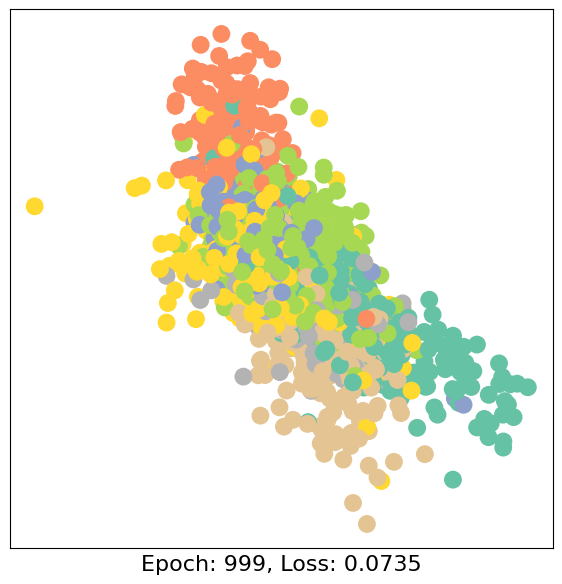

In [16]:
#torch.manual_seed(35)

optimizer_name = "Adam"
lr = 0.0001
weight_decay=0.001
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr,weight_decay=weight_decay)
epochs = 1000

def train():
  model.train()
  optimizer.zero_grad()
  out,x=model()
  #print(out)
  # print(model()[data.train_mask], data.y[data.train_mask])
  #loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
  loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss, x
    

@torch.no_grad()
def test():
  model.eval()
  logits,_ = model()
  #print(logits)
  mask1 = data['train_mask']
  pred1 = logits[mask1].max(1)[1]
  acc1 = pred1.eq(data.y[mask1]).sum().item() / mask1.sum().item()
  mask = data['test_mask']
  pred = logits[mask].max(1)[1]
  lossT = F.cross_entropy(logits[mask], data.y[mask])
  acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
  return acc1,acc,lossT


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()
    
    
best_val_acc = test_acc = 0
for epoch in range(1,epochs):
    loss, x =train()
    train_acc,test_acc,lossT = test()
    #print('#' * 70)
    #print('Train Accuracy: %s' %train_acc )
    #print('Test Accuracy: %s' % test_acc)
    #print('#' * 70)  
    log = 'Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}, Loss: {:.4f}, Loss Test: {:.4f}'
    if epoch % 50 == 0:
        print(log.format(epoch, train_acc, test_acc,loss,lossT))
print(x.shape)
visualize_embedding(x, color=data.y, epoch=epoch, loss=loss)